# DIS25 Natural Language Processing
### Untersuchung Gender Bias im Deutschen Bundestag  

Gruppe: Dennis Depoi, Leonie Schulz, Annemarie Szyprons, Melanie Ullrich  
Gruppenname: MüssenWirÜberlegen  

### 1. Initialisieren

In [1]:
# settings, imports & downloads

import pandas as pd
import os
from bs4 import BeautifulSoup
import re
import numpy as np
import nltk
import matplotlib.pyplot as plt
from textblob_de import TextBlobDE as TextBlob
nltk.download('punkt')

nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("omw-1.4")
nltk.download("averaged_perceptron_tagger")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Ulli\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Ulli\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Ulli\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Ulli\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Ulli\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

### 2. Einlesen der Daten

#### 2.1. Plenarprotokolle

In [2]:
# read xml files
folder_path = "data"
files_in_folder = os.listdir(folder_path)

result = []

for file in files_in_folder:
    soup = BeautifulSoup(open(folder_path + "/" + file, "r", encoding="utf-8"), "xml")
    d = {}
    for tag in soup.find_all(recursive=True):
        d[tag.name] = tag.get_text(strip=True)
        result.append(d)
        
df = pd.DataFrame(result) # write in dataframe
df = df.drop_duplicates() # remove duplicated rows from dataframe
df = df.drop(columns = "DOKUMENT") # remove redundant column

In [3]:
df

,WAHLPERIODE,DOKUMENTART,NR,DATUM,TITEL,TEXT
0,15,PLENARPROTOKOLL,15/1,17.10.2002,Plenarprotokoll vom 17.10.2002,Tagesordnungspunkt 1:\nEröffnung der Sitzung d...
7,15,PLENARPROTOKOLL,15/2,22.10.2002,Plenarprotokoll vom 22.10.2002,Tagesordnungspunkt 1:\nWahl des Bundeskanzlers...
14,15,PLENARPROTOKOLL,15/3,23.10.2002,Plenarprotokoll vom 23.10.2002,Tagesordnungspunkt 5:\n\nBeratung und Beschlus...
21,15,PLENARPROTOKOLL,15/4,29.10.2002,Plenarprotokoll vom 29.10.2002,Tagesordnungspunkt 1:\nRegierungserklärung des...
28,15,PLENARPROTOKOLL,15/5,30.10.2002,Plenarprotokoll vom 30.10.2002,Erweiterung der Tagesordnung . . . . . . . . ...
...,...,...,...,...,...,...
4669,17,PLENARPROTOKOLL,17/249,26.06.2013,Plenarprotokoll vom 26.06.2013,Plenarprotokoll 17/249\nDeutscher Bundestag\nS...
4676,17,PLENARPROTOKOLL,17/250,27.06.2013,Plenarprotokoll vom 27.06.2013,Plenarprotokoll 17/250Plenarprotokoll 17/250\n...
4683,17,PLENARPROTOKOLL,17/251,28.06.2013,Plenarprotokoll vom 28.06.2013,Plenarprotokoll 17/251\nDeutscher Bundestag\nS...
4690,17,PLENARPROTOKOLL,17/252,02.09.2013,Plenarprotokoll vom 02.09.2013,Plenarprotokoll 17/252\nDeutscher Bundestag\nS...


#### 2.2. Stammdaten 

In [4]:
gender_df = pd.read_csv("DIS25_liste_gender.csv", delimiter=";") # read csv file of the names, parties and genders
# transform into lists
names = gender_df["Vorname_Nachname"].tolist()
geschlechter = gender_df["Geschlecht"].tolist()
partei = gender_df["Fraktion"].tolist()

In [5]:
gender_df

,Vorname_Nachname,Nachname,Vorname,Geschlecht,Fraktion
0,Jens Ackermann,Ackermann,Jens,m,FDP
1,Christian Ahrendt,Ahrendt,Christian,m,FDP
2,Ilse Aigner,Aigner,Ilse,f,CDU/CSU
3,Jan van Aken,van Aken,Jan,m,DIE LINKE
4,Agnes Alpers,Alpers,Agnes,f,DIE LINKE
...,...,...,...,...,...
647,Sabine Zimmermann,Zimmermann,Sabine,f,DIE LINKE
648,Wolfgang Zöller,Zöller,Wolfgang,m,CDU/CSU
649,Manfred Helmut Zöllmer,Zöllmer,Manfred Helmut,m,SPD
650,Willi Zylajew,Zylajew,Willi,m,CDU/CSU


### 3. Datentransformation  
Der Protokolltext wird in eine neue Spalte `TEXT_SPLIT` übertragen. Der eigentliche Protokollinhalt beginnt bei `Beginn` und endet bei `Schluss`. Anhand dieser Merkmale wird der Text getrennt. 

In [6]:
# split column "TEXT" and add only the important text into new column and the participants
conversation = []
pattern_start = "Beginn:"
pattern_end = "Schluss:"

for row in df["TEXT"]:
    rowstr = str(row).split(pattern_start)
    conversation.append(rowstr[1])

df["TEXT_SPLIT"] = conversation

Die Spalte `TEXT_SPLIT` wird zu Beginn gereinigt, indem Absätze und doppelte Leerzeichen und einige Titel entfernt werden.

In [7]:
# clean data
df["TEXT_SPLIT"] = df.apply(lambda row: re.sub("(\n)|(\r)|(\s+)", " ", row["TEXT_SPLIT"]), axis=1) # remove returns in data
df["TEXT_SPLIT"] = df.apply(lambda row: re.sub("-\s", "", row["TEXT_SPLIT"]), axis=1) # remove separate words with hyphen

#### 3.1. Erstellen eines Sub-Dataframes zur Erweiterung der Daten
Die Textdaten werden in weitere Spalten untergliedert, die den Redebeitrag, die vortragende Person sowie die Unterbrechung beinhalten.

In [8]:
# write the components of speaker, speech and interruption
Sub = set() # only unique values in set to avoid the same text with different name

for row in df["TEXT_SPLIT"]:
    for i in names:
        x = str(i) + ":"
        if x in row:
            name = x
            start = str(row).index(name) # speach starts with name + : 
            end = row.index(")", start+1) # speach ends when first interruption starts in brackets 
            substring = row[start-1:end+1]
            Sub.add(substring)
        else:
            # if the substring has no name in it, it is the speach of the speaker before the new substring
            # because sometimes the speach will go on without calling the name in the protocol again
            start = str(row).index(")") # speach starts with closed brackets
            end = row.index(")", start+1) # speach ends when second interruption starts in brackets 
            substring = row[start+2:end+1] # substring without name
            if len(Sub) > 0:
                last_element = str(list(Sub)[-1]) # last speach element of Sub
                if name in last_element:
                    substring = name + substring # concatenate name of last speaker + speach 
                    if substring not in Sub:
                        Sub.add(substring)
                        
Sub = list(Sub)

In [9]:
len(Sub)

3303

Subdataframe wird in einem neuen Dataframe verbunden. 

In [10]:
# split the components and write into new dataframe
data = pd.DataFrame()
Redebeitrag = []
Person = []
Unterbrechung = []

for x in Sub:
    string = re.split(":", str(x), 1) # split where : is
    string1 = re.split("\\(|\\)", str(string[1])) # split interruption when in brackets
    Person.append(string[0])
    Redebeitrag.append(string1[0])
    Unterbrechung.append(string1[1])

data["Redeinhalt"] = Redebeitrag
data["Vortragende_Person"] = Person
data["Unterbrechung"] = Unterbrechung

In [11]:
# drop columns where interruption is party
for unterbrechung in data["Unterbrechung"]:
    for p in partei:
        data.drop(data.index[data["Unterbrechung"] == p], inplace = True)

In [12]:
# sometimes before interruption text, something happens - the person starts talking then after "-"
char = "–"
pattern  = ".*" + char  # Regex pattern to match all characters on and before '-'
clean_unterhaltung = []

for row in data["Unterbrechung"]:
    if re.findall(pattern, row):
        clean_str = re.sub(pattern, "", row) # remove all characters before the character '-' from string 
        clean_unterhaltung.append(clean_str)
    else:
        clean_unterhaltung.append(row)
        
data["Unterbrechung"] = clean_unterhaltung

In [13]:
# split the interruption-components and add to dataframe
pers_unter = []
rede_unter = []
partei_unter = []

for row in data["Unterbrechung"]:
    if re.findall(r":", row):
        string = re.split(':', str(row))
        str_pers = re.split("\[\w+.*\/?\w*?.\w*\]$", string[0])
        str_part = re.findall("\[\w+.*\/?\w*?.\w*\]$", string[0])
        if len(str_part) > 0:
            str_part = re.sub("\[?\]?", "", str_part[0]) # remove [] brackets
        pers_unter.append(str_pers[0])
        rede_unter.append(string[1])
        partei_unter.append(str_part)
    else:
        pers_unter.append("") # add NULL if no person interrupts
        partei_unter.append("")
        rede_unter.append("")

data["Person_Unterbrechung"] = pers_unter
data["Partei_Unterbrechung"] = partei_unter
data["Redeinhalt_Unterbrechung"] = rede_unter

In [14]:
# print new dataframe 
data

,Redeinhalt,Vortragende_Person,Unterbrechung,Person_Unterbrechung,Partei_Unterbrechung,Redeinhalt_Unterbrechung
0,"Interfraktionell ist vereinbart worden, die ve...",Wolfgang Thierse,Vermittlungsausschuss,,,
1,"Mit tiefer Betroffenheit haben wir erfahren, ...",Wolfgang Thierse,,,,
5,"Herr Kollege Reichel, das war Ihre erste Rede...",Gerda Hasselfeldt,Beifall,,,
7,"Guten Morgen, liebe Kolleginnen und Kollegen!...",Wolfgang Thierse,Die Anwesenden erheben sich,,,
8,"Guten Morgen, liebe Kolleginnen und Kollegen!...",Susanne Kastner,,,,
...,...,...,...,...,...,...
3296,Ist die Bundesregierung angesichts der andau...,Inge Höger,Anhaltender Beifall bei der LINKEN,,,
3297,Auf welcher Grundlage hat die Bundesregierung...,Wolfgang Wieland,vergleiche den „Hauptstadtbrief“ Nr. 72 vom De...,,,
3299,ZP 2 Weitere Überweisungen im vereinfachten V...,Wolfgang Thierse,,,,
3300,Die Sitzung ist eröffnet. Liebe Kolleginnen u...,Norbert Lammert,Renate Künast [BÜNDNIS 90/DIE GRÜNEN]: Er fei...,Renate Künast,BÜNDNIS 90/DIE GRÜNEN,Er feiert noch!


#### 3.2. Datenbereinigung  
Für eine genauere Zuordnung der Namen, Geschlechter und Fraktionen zu den Unterbrechungen, werden die Daten (erneut) in diesem Schritt bereinigt.

In [15]:
# Cleaning person of interruption
person_clean = []

for person in data["Person_Unterbrechung"]:
    new_person = re.sub("Dr\.|Prof\.|Dr\.\sh\.\sc\.|Präsident??|Bundesminister??|Alterspräsident??|Vizepräsident??|Gegenruf des Abg\.|h\. c\.|Gegenruf der Abg\.", "", person) # remove title
    new_person = re.sub("Financial Times Deutschland vom 28. September 2011; Spiegel Online", "0", new_person)
    new_person = new_person.strip() # remove leading and tailing whitespaces
    new_person = re.sub(r'[^\w\s]', '', new_person) # remove punctuation
    person_clean.append(new_person)

data["Person_Unterbrechung"] = person_clean

In [16]:
test_clean_person = data["Person_Unterbrechung"].tolist()
set(test_clean_person)

{'',
 '0',
 'AZ',
 'Alexander Dobrindt',
 'Andreas Mattfeldt',
 'Angelica SchwallDüren',
 'Axel Troost',
 'Aydan Özoğuz',
 'Barbara Höll',
 'Bartholomäus Kalb',
 'Beifall bei der FDP  Birgitt Bender',
 'Beifall bei der SPD  Torsten Staffeldt',
 'Britta Haßelmann',
 'Bärbel Kofler',
 'CarlLudwig Thiele',
 'Carsten Sieling',
 'Christian Lange',
 'Christian Lindner',
 'Christian Ruck',
 'Christine Scheel',
 'Claudia Roth',
 'Dagmar Enkelmann',
 'Dagmar Freitag',
 'Dieter Wiefelspütz',
 'Dietrich Austermann',
 'Dirk Niebel',
 'Doris Barnett',
 'Eckart von Klaeden',
 'Eduard Oswald',
 'Elke Ferner',
 'Ernst Burgbacher',
 'Ernst Hinsken',
 'Florian Pronold',
 'Franz Josef Jung',
 'Fritz Kuhn',
 'Gabriele HillerOhm',
 'Garrelt Duin',
 'Gegenruf von der FDP',
 'Gegenrufe von der SPD',
 'Georg Nüßlein',
 'Georg Schirmbeck',
 'Gernot Erler',
 'Gesine Lötzsch',
 'Guido Westerwelle',
 'Guido Westerwelle r',
 'Gustav Herzog',
 'HansJoachim Otto',
 'Hartmut Koschyk',
 'Hartmut Schauerte',
 'Heinrich

In [17]:
# Cleaning party from person of interruption
party_clean = []

for party in data["Partei_Unterbrechung"]:
    party = str(party)
    new_party = re.sub(r"\/\s", "/", party) # remove whitespace after / 
    new_party = re.sub("Bayreuth|Backnang|Augsburg|Frankfurt|Heringen|Köln|Koblenz|Aachen|Peine|Erlangen|Kyffhäuser|Saarbrücken|Salzgitter", "", new_party)
    new_party = new_party.strip()
    party_clean.append(new_party)

data["Partei_Unterbrechung"] = party_clean

In [18]:
test_clean_party = data["Partei_Unterbrechung"].tolist()
set(test_clean_party)

{'',
 'Bayreuth FDP',
 'BÜNDNIS 90/DIE GRÜNEN',
 'CDU/CSU',
 'DIE LINKE',
 'FDP',
 'Frankfurt FDP',
 'Heringen SPD',
 'SPD',
 'Saarbrücken DIE LINKE',
 'Salzgitter SPD',
 '[]',
 'fraktionslos'}

#### 3.3. Daten zusammenfügen
Die Namen werden nun mit den Stammdaten abgeglichen und verschnitten, sodass die Geschlechter den jeweiligen Personen zugeordnet werden können.

In [19]:
data_clean = data

In [20]:
# matching process to indetify gender
gender_pers_speach = []

for person in data_clean["Vortragende_Person"]:
    person = person.strip() # removing leading and trailing whitespaces
    if person in names:
        index = names.index(person)
        geschlecht = geschlechter[index]
        gender_pers_speach.append(geschlecht)
    else:
        gender_pers_speach.append("")

data_clean["Geschlecht_vort_Pers"] = gender_pers_speach

In [21]:
gender_pers_interruption = []

for person in data_clean["Person_Unterbrechung"]:
    person = person.strip() # removing leading and trainling whitespaces
    if person in names:
        index = names.index(person)
        geschlecht = geschlechter[index]
        gender_pers_interruption.append(geschlecht)
    else:
        gender_pers_interruption.append("")
        
data_clean["Geschlecht_unterb_Pers"] = gender_pers_interruption

In [22]:
data_clean

,Redeinhalt,Vortragende_Person,Unterbrechung,Person_Unterbrechung,Partei_Unterbrechung,Redeinhalt_Unterbrechung,Geschlecht_vort_Pers,Geschlecht_unterb_Pers
0,"Interfraktionell ist vereinbart worden, die ve...",Wolfgang Thierse,Vermittlungsausschuss,,,,m,
1,"Mit tiefer Betroffenheit haben wir erfahren, ...",Wolfgang Thierse,,,,,m,
5,"Herr Kollege Reichel, das war Ihre erste Rede...",Gerda Hasselfeldt,Beifall,,,,f,
7,"Guten Morgen, liebe Kolleginnen und Kollegen!...",Wolfgang Thierse,Die Anwesenden erheben sich,,,,m,
8,"Guten Morgen, liebe Kolleginnen und Kollegen!...",Susanne Kastner,,,,,f,
...,...,...,...,...,...,...,...,...
3296,Ist die Bundesregierung angesichts der andau...,Inge Höger,Anhaltender Beifall bei der LINKEN,,,,f,
3297,Auf welcher Grundlage hat die Bundesregierung...,Wolfgang Wieland,vergleiche den „Hauptstadtbrief“ Nr. 72 vom De...,,,,m,
3299,ZP 2 Weitere Überweisungen im vereinfachten V...,Wolfgang Thierse,,,,,m,
3300,Die Sitzung ist eröffnet. Liebe Kolleginnen u...,Norbert Lammert,Renate Künast [BÜNDNIS 90/DIE GRÜNEN]: Er fei...,Renate Künast,BÜNDNIS 90/DIE GRÜNEN,Er feiert noch!,m,f


### 4. Sentiment Analyse

In [23]:
sent_pol = [] # empty list
sent_sub = [] # empty list

for row in data_clean["Redeinhalt_Unterbrechung"]:
    if row != "":
        blob = TextBlob(row)
        # sentiment analysis
        sent_pol.append(blob.sentiment.polarity)
        sent_sub.append(blob.sentiment.subjectivity)
    else:
        sent_pol.append("")
        sent_sub.append("")
        
data_clean["Polarity"] = sent_pol
data_clean["Subjectivity"] = sent_sub

### 5. Auswertung und Analyse der Daten  
Mit Hilfe des erzeugten Dataframes können im Anschluss Analysen zur Beantwortung folgender Fragestellungen beantwortet werden:  
* Verteilung der Redebeiträge zwischen Männern und Frauen im Verhältnis zur allgemeinen Verteilung der Abgeordneten im Deutschen Bundestag  
* Verteilung der Redeunterbrechung zwischen Männern und Frauen  
* Die meist unterbrechende Partei (inklusive Geschlecht)  
* Relative Verteilung der Geschlechter - Wer unterbricht wen?
* Sentiment Analyse der Redeunterbrechungen nach Geschlecht

In [24]:
auswertung = data_clean

In [25]:
auswertung = auswertung[auswertung["Geschlecht_vort_Pers"] != ""] # only if gender is available in data

Durch einen Test wird ermittelt, dass `0 Zeilen` aus den Daten herausgenommen werden, aufgrund eines nicht zuordbaren Geschlechts. 

In [26]:
len(data_clean) - len(auswertung)

1

#### 5.1. Relative und absolute Häufigkeit der Redebeiträge von Männern und Frauen im Deutschen Bundestag

In [27]:
# for not unique values
absolute_frequencies = auswertung["Geschlecht_vort_Pers"].value_counts().rename_axis('Geschlecht').reset_index(name="Absolut")
relative_frequencies = auswertung["Geschlecht_vort_Pers"].value_counts(normalize=True).rename_axis('Geschlecht').reset_index(name="Relativ")


print("Absolute Häufigkeit:\n",absolute_frequencies,"\n")
print("Relative Häufigkeit:\n",relative_frequencies)

Absolute Häufigkeit:
   Geschlecht  Absolut
0          m     1654
1          f      821 

Relative Häufigkeit:
   Geschlecht   Relativ
0          m  0.668283
1          f  0.331717


#### 5.2.  Relative und absolute Häufigkeit der Unterbrechungen von Männern und Frauen im Deutschen Bundestag

In [28]:
# for not unique values
interruptions = auswertung[auswertung["Geschlecht_unterb_Pers"] != ""]
absolute_frequencies_inter = interruptions["Geschlecht_unterb_Pers"].value_counts().rename_axis('Geschlecht').reset_index(name="Absolut")
relative_frequencies_inter = interruptions["Geschlecht_unterb_Pers"].value_counts(normalize=True).rename_axis('Geschlecht').reset_index(name="Relativ")

print("Absolute Häufigkeit:\n", absolute_frequencies_inter, "\n")
print("Relative Häufigkeit:\n", relative_frequencies_inter)

Absolute Häufigkeit:
   Geschlecht  Absolut
0          m      142
1          f       45 

Relative Häufigkeit:
   Geschlecht   Relativ
0          m  0.759358
1          f  0.240642


Es ist bereits hier zu erkennen, dass die Verteilung von Männern und Frauen bei den Redebeiträgen und Unterbrechungen sehr ähnlich ist. Grundsätzlich lässt sich erkennen, dass Vorträge häufiger von Männern gehalten werden sowie Unterbrechungen häufiger durch Männer passieren.  
Nun sollen die Verteilungen in einer Grafik visualisiert werden.

In [29]:
# concetenate dataframes
relative_frequencies["Merkmal"] = "Redebeitrag"
relative_frequencies_inter["Merkmal"] = "Unterbrechung"

frames = [relative_frequencies, relative_frequencies_inter]
result = pd.concat(frames, ignore_index=True, sort=False)
# relative frequencies in percent
result["Relativ"] = result["Relativ"]*100

In [30]:
# reform table (wider)
result = result.pivot_table(index=["Merkmal"], 
                    columns="Geschlecht", 
                    values="Relativ")

In [31]:
result

Geschlecht,f,m
Merkmal,,
Redebeitrag,33.171717,66.828283
Unterbrechung,24.064171,75.935829


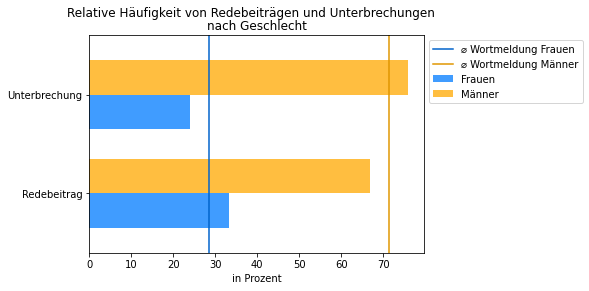

In [32]:
# data visualization
mean_freq_fem = result["f"].mean()
mean_freq_men = result["m"].mean()

# plotting a bar chart
result.plot(kind = "barh",
        width = 0.7, color = ["#409cff", "#ffbe40"])

plt.axvline(x = mean_freq_fem, color = "#0063CC") # vertical line mean female
plt.axvline(x = mean_freq_men, color = "#E09600") # vertical line mean men
plt.xlabel("in Prozent") # naming the x-axis
plt.ylabel("") # naming the y-axis
plt.title("nach Geschlecht") # plot title
plt.suptitle("Relative Häufigkeit von Redebeiträgen und Unterbrechungen") # plot title
plt.legend(["⌀ Wortmeldung Frauen", "⌀ Wortmeldung Männer", "Frauen", "Männer"], loc="upper left", bbox_to_anchor=(1,1))
  
plt.show() # show plot

In dieser Grafik werden die relativen Häufigkeiten von Redebeiträgen und Unterbrechungen nach Geschlecht aufgezeigt. Die vertikalen Linien zeigen den durchschnittlichen Wortbeitrag von Frauen sowie Männern insgesamt. Die Differenz des durchschnittlichen Anteils liegt bei rund 32 Prozent, was eine hohe Differenz darstellt. 

#### 5.3. Die meist unterbrechende Partei (inklusive Geschlecht) 

In [33]:
party_inter = auswertung[auswertung["Geschlecht_unterb_Pers"] != ""] # only if gender is available

In [34]:
party_inter = party_inter.groupby(["Partei_Unterbrechung", "Geschlecht_unterb_Pers"]).size().reset_index(name='Anzahl')

In [35]:
# reform table (wider)
party_inter_res = party_inter.pivot_table(index=["Partei_Unterbrechung"], 
                    columns="Geschlecht_unterb_Pers", 
                    values="Anzahl")

In [36]:
party_inter_res

Geschlecht_unterb_Pers,f,m
Partei_Unterbrechung,,
BÜNDNIS 90/DIE GRÜNEN,12.0,20.0
CDU/CSU,2.0,50.0
DIE LINKE,17.0,7.0
FDP,2.0,35.0
Heringen SPD,NaN,1.0
SPD,11.0,29.0
fraktionslos,1.0,NaN


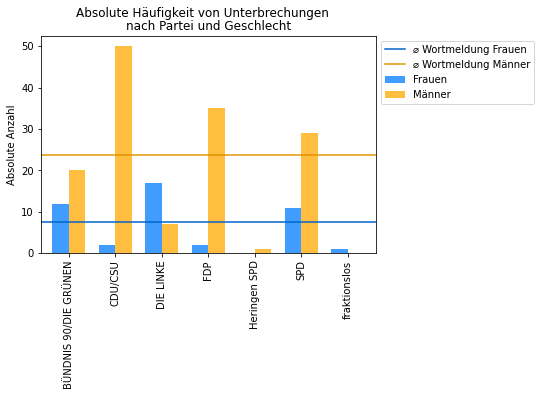

In [37]:
# data visualization
mean_freq_fem2 = party_inter_res["f"].mean() # for row average
mean_freq_men2 = party_inter_res["m"].mean()

# plotting a bar chart
party_inter_res.plot(kind = "bar",
        width = 0.7, color = ["#409cff", "#ffbe40"])

plt.axhline(y=mean_freq_fem2, color= "#0063CC") # average frequency female
plt.axhline(y=mean_freq_men2, color= "#E09600") # average frequency men
plt.xlabel("") # naming the x-axis
plt.ylabel("Absolute Anzahl") # naming the y-axis
plt.title("nach Partei und Geschlecht") # plot title
plt.suptitle("Absolute Häufigkeit von Unterbrechungen") # plot title
plt.legend(["⌀ Wortmeldung Frauen", "⌀ Wortmeldung Männer", "Frauen", "Männer"], loc="upper left", bbox_to_anchor=(1,1))
  
plt.show() # show plot

In dieser Grafik ist gut zu erkennen, dass in der Partei "Die Linke" eindeutig mehr Frauen die Redebeiträge unterbrechen. Der Durchschnitt zeigt erneut, dass grundsätzlich mehr Männer die Redebeiträge unterbrechen. In der Partei "Bündis 90/Die Grünen) sind die absoluten Anzahlen relativ ähnlich.  
Die Partei, die die meisten Wortunterbrechungen hat ist SPD, die FDP hält sich im Gegensatz dazu sehr zurück.

#### 5.4. Relative Verteilung der Geschlechter - Wer unterbricht wen? 

In [38]:
gender_inter = auswertung[auswertung["Geschlecht_unterb_Pers"] != ""] # only if gender is available
gender_inter = gender_inter.groupby(["Geschlecht_unterb_Pers", "Geschlecht_vort_Pers"]).size().reset_index(name='Anzahl')

In [39]:
gender_inter

,Geschlecht_unterb_Pers,Geschlecht_vort_Pers,Anzahl
0,f,f,13
1,f,m,32
2,m,f,41
3,m,m,101


In [40]:
# calculate relative frequency
fems = gender_inter[gender_inter["Geschlecht_unterb_Pers"] == "f"]
men = gender_inter[gender_inter["Geschlecht_unterb_Pers"] == "m"]

total_num_f = fems.Anzahl.sum()
total_num_m = men.Anzahl.sum()

rel_freq_f = []
for n in fems["Anzahl"]:
    num_f = n/total_num_f*100
    rel_freq_f.append(num_f)

rel_freq_m = []
for n in men["Anzahl"]:
    num_m = n/total_num_m*100
    rel_freq_m.append(num_m)
    

fems["Relativ"] = rel_freq_f
men["Relativ"] = rel_freq_m 

# to drop column "Anzahl" and "Geschlecht_unterb_Pers"
fems = fems.drop(["Anzahl", "Geschlecht_unterb_Pers"], axis=1)
men = men.drop(["Anzahl", "Geschlecht_unterb_Pers"], axis=1) # to drop column "Anzahl"

C:\Users\Ulli\AppData\Local\Temp\ipykernel_6612\1984627187.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fems["Relativ"] = rel_freq_f
C:\Users\Ulli\AppData\Local\Temp\ipykernel_6612\1984627187.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  men["Relativ"] = rel_freq_m


In [41]:
# concetenate dataframes
fems["Wird_unterbrochen_von"] = "Frau"
men["Wird_unterbrochen_von"] = "Mann"

frames = [fems, men]
result_genders = pd.concat(frames, ignore_index=True, sort=False)
result_genders

,Geschlecht_vort_Pers,Relativ,Wird_unterbrochen_von
0,f,28.888889,Frau
1,m,71.111111,Frau
2,f,28.873239,Mann
3,m,71.126761,Mann


In [42]:
# reform table (wider)
result_genders = result_genders.pivot_table(index=["Wird_unterbrochen_von"], 
                    columns="Geschlecht_vort_Pers", 
                    values="Relativ")

In [43]:
result_genders

Geschlecht_vort_Pers,f,m
Wird_unterbrochen_von,,
Frau,28.888889,71.111111
Mann,28.873239,71.126761


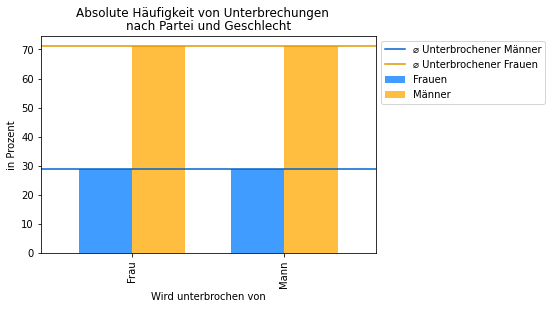

In [44]:
# data visualization
mean_freq_inter_fem = result_genders["f"].mean() # for row average
mean_freq_inter_men = result_genders["m"].mean()

# plotting a bar chart
result_genders.plot(kind = "bar",
        width = 0.7, color = ["#409cff", "#ffbe40"])

plt.axhline(y=mean_freq_inter_fem, color= "#0063CC") # average frequency female
plt.axhline(y=mean_freq_inter_men, color= "#E09600") # average frequency men
plt.xlabel("Wird unterbrochen von") # naming the x-axis
plt.ylabel("in Prozent") # naming the y-axis
plt.title("nach Partei und Geschlecht") # plot title
plt.suptitle("Absolute Häufigkeit von Unterbrechungen") # plot title
plt.legend(["⌀ Unterbrochener Männer", "⌀ Unterbrochener Frauen", "Frauen", "Männer"], loc="upper left", bbox_to_anchor=(1,1))
  
plt.show() # show plot

Es ist zu erkennen, dass Männer durchschnittlich häufiger unterbrochen werden als Frauen. Hierbei zeigt die Grafik, dass sowohl Männer das gleiche Geschlecht, als auch Frauen Männer häufiger unterbrechen.

#### 5.5. Sentiment Analyse der Redeunterbrechungen nach Geschlecht

In [45]:
# sentiment tendencies of interruption
# above 0.5 = positive
# 0.0 = neutral
# below -0.49  = negative
tendency = []
for p in auswertung["Polarity"]:
    if p != "":
        if p > 0.0:
            sent = "positive"
            tendency.append(sent)
        elif p == 0.0:
            sent = "neutral"
            tendency.append(sent)
        else:
            sent = "negative"
            tendency.append(sent)
    else:
        tendency.append("")

auswertung["Sentiment_Tendenz"] = tendency

C:\Users\Ulli\AppData\Local\Temp\ipykernel_6612\2915807098.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  auswertung["Sentiment_Tendenz"] = tendency


In [46]:
sentiment_notNull = auswertung[auswertung["Sentiment_Tendenz"] != ""]
sentiment_notNull = sentiment_notNull[sentiment_notNull["Geschlecht_unterb_Pers"] != ""]

In [47]:
sentiment = sentiment_notNull.groupby(["Geschlecht_unterb_Pers", "Sentiment_Tendenz"]).size().reset_index(name='Anzahl')

In [48]:
# calculate relative frequency
fems = sentiment[sentiment["Geschlecht_unterb_Pers"] == "f"]
men = sentiment[sentiment["Geschlecht_unterb_Pers"] == "m"]

total_num_f = fems.Anzahl.sum()
total_num_m = men.Anzahl.sum()

rel_freq_f = []
for n in fems["Anzahl"]:
    num_f = n/total_num_f*100
    rel_freq_f.append(num_f)

rel_freq_m = []
for n in men["Anzahl"]:
    num_m = n/total_num_m*100
    rel_freq_m.append(num_m)
    

fems["Anteil"] = rel_freq_f
men["Anteil"] = rel_freq_m 

C:\Users\Ulli\AppData\Local\Temp\ipykernel_6612\3265206689.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fems["Anteil"] = rel_freq_f
C:\Users\Ulli\AppData\Local\Temp\ipykernel_6612\3265206689.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  men["Anteil"] = rel_freq_m


In [49]:
# concetenate dataframes
frames = [fems, men]
sentiment_res = pd.concat(frames, ignore_index=True, sort=False)
sentiment_res

,Geschlecht_unterb_Pers,Sentiment_Tendenz,Anzahl,Anteil
0,f,negative,3,6.666667
1,f,neutral,30,66.666667
2,f,positive,12,26.666667
3,m,negative,11,7.746479
4,m,neutral,101,71.126761
5,m,positive,30,21.126761


In [50]:
# reform table (wider)
sentiment_res = sentiment_res.pivot_table(index=["Sentiment_Tendenz"], 
                    columns="Geschlecht_unterb_Pers", 
                    values="Anteil")

In [51]:
sentiment_res

Geschlecht_unterb_Pers,f,m
Sentiment_Tendenz,,
negative,6.666667,7.746479
neutral,66.666667,71.126761
positive,26.666667,21.126761


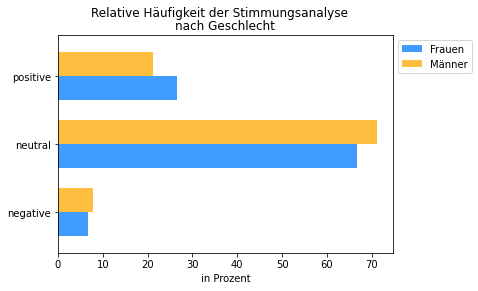

In [52]:
# data visualization
# plotting a bar chart
sentiment_res.plot(kind = "barh",
        width = 0.7, color = ["#409cff", "#ffbe40"])

plt.xlabel("in Prozent") # naming the x-axis
plt.ylabel("") # naming the y-axis
plt.title("nach Geschlecht") # plot title
plt.suptitle("Relative Häufigkeit der Stimmungsanalyse") # plot title
plt.legend(["Frauen", "Männer"], loc="upper left", bbox_to_anchor=(1,1))
  
plt.show() # show plot